In [51]:
import os
import pickle
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import scipy.stats as stats


In [52]:
with open("../data/processed/dataset2.pickle","rb") as reader:
    df=pickle.load(reader)

In [53]:
df.head(5)

,Player,Tm,Salary,Year,Pos,Age,G,GS,MP,FG,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FA
0,Stephen Curry,Golden State Warriors,37457154,2018,PG,29.0,51.0,51.0,32.0,8.4,...,31.0,7.2,1.9,9.1,0.267,9.9,-1.3,8.6,4.4,No
1,Russell Westbrook,Oklahoma City Thunder,35654150,2018,PG,29.0,80.0,80.0,36.4,9.5,...,34.1,5.5,4.5,10.1,0.166,5.1,3.1,8.2,7.5,No
2,Chris Paul,Houston Rockets,35654150,2018,PG,32.0,58.0,58.0,31.8,6.3,...,24.5,7.5,2.7,10.2,0.265,6.2,0.9,7.1,4.3,Yes
3,Blake Griffin,Detroit Pistons,32088932,2018,PF,28.0,58.0,58.0,34.0,7.5,...,28.9,3.2,1.8,4.9,0.120,2.9,-0.1,2.8,2.4,No
4,Gordon Hayward,Boston Celtics,31214295,2018,SF,27.0,1.0,1.0,5.0,1.0,...,17.9,0.0,0.0,0.0,0.056,-5.9,-6.1,-12.0,0.0,No


In [54]:
df = df[~df['FA'].isnull()]

In [55]:
df=df.fillna(0)

In [56]:
df.columns

Index(['Player', 'Tm', 'Salary', 'Year', 'Pos', 'Age', 'G', 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', 'FA'],
      dtype='object')

Before we proceed, we can eliminate some of the columns as they can be defined in terms of the other. 

$FG\% = \frac{FG}{FGA}$

$eFG\% = \frac{FG+\left(0.5*3P\right)}{FGA}$

$3P\% = \frac{3P}{3PA}$

$2P\% = \frac{2P}{2PA}$

$FT\% = \frac{FT}{FTA}$

$TRB = ORB+DRB$

$TRB\% = ORB\% + DRB\%$

$WS = OWS+DWS$

$BPM = OBPM + DBPM$

$WS/48 = \frac{WS}{48 min}$

$TS\% = \frac{PTS}{2\left(FGA+(0.44*FTA)\right)}*100$

$3PAr = \frac{3PA}{FGA}$

$FTr = \frac{FTA}{FGA}$

We can eliminate at least 5 columns to make things easier. Also I choose to leave our year since we no longer need it for the categorization although it may be put back in for improvements.

In [104]:
columns=['Year', 'Pos', 'Age', 'G', 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', 'Salary']

In [105]:
df_small=df[columns]

In [106]:
df_small["cuberoot"] = np.cbrt(df_small["Salary"])
df_small["sqrt"]=df_small["Salary"]**0.5
df_small["log"]=np.log10(df_small["Salary"])

/Users/youngjeong/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/youngjeong/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


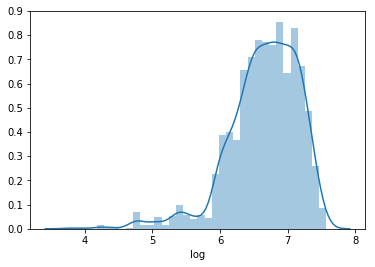

In [107]:
sns.distplot(df_small["log"])

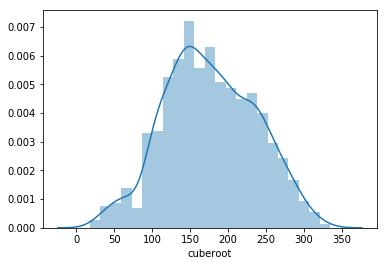

In [108]:
sns.distplot(df_small["cuberoot"])

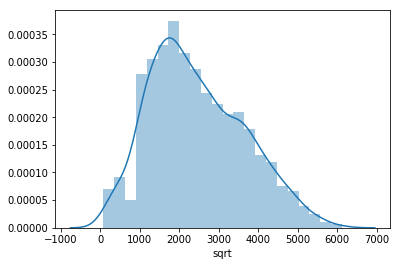

In [109]:
sns.distplot(df_small["sqrt"])

In [110]:
# sns.pairplot(df_small)

In [120]:
# df_small.corr()

In [112]:
X = df_small[df_small.columns[:-4]]

In [137]:
def lr_test(dataset, target):
    test = dataset[dataset.Year == 2018]
    train = dataset[dataset.Year != 2018]
    
    X_test, y_test = pd.get_dummies(test[test.columns[:-4]]), test[target]
    X_train, y_train = pd.get_dummies(train[train.columns[:-4]]), train[target]
#     print(X_train.head().T)
    
#     print(X_test.shape, X_train.shape)
#     print(len(y_test), len(y_train))
    
    lr = LinearRegression()
    # Fit the model to the full dataset
    lr.fit(X_train, y_train)

    # Print out the R^2 for the model against the full dataset
    print("Training Data R2 score: ", lr.score(X_train, y_train))
    
    y_pred = lr.predict(X_test)
    
    print("Test Data R2 score: ", r2_score(y_test,y_pred))
    print("sqrt MSE: ", np.sqrt(mean_squared_error(y_test,y_pred)))
    
    res = y_test - y_pred
#     plt.scatter(y_pred, res)
    plt.scatter(y_pred,y_test)
    plt.title("Residual Plot of 2018 NBA Salary Prediction")
    plt.xlabel("Prediction (10 Million $)")
    plt.ylabel("Residuals (10 Million $)")
    
    return lr

Training Data R2 score:  0.5810485636277036
Test Data R2 score:  0.4456144926295874
sqrt MSE:  6332049.887692532


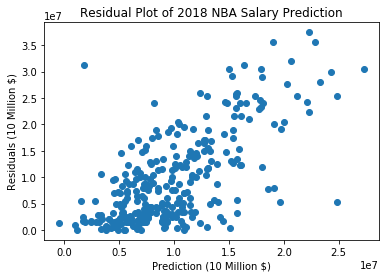

In [138]:
lr_reg = lr_test(df_small, "Salary")

Training Data R2 score:  0.44885619766670437
Test Data R2 score:  0.27149639155235683
sqrt MSE:  0.493638484700625


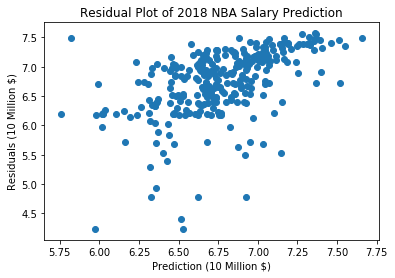

In [139]:
lr_log = lr_test(df_small, "log")

Training Data R2 score:  0.542024926692809
Test Data R2 score:  0.38098826224724625
sqrt MSE:  53.747993972593996


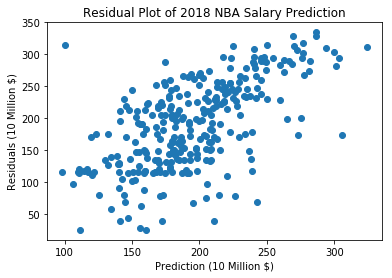

In [140]:
lr_cube = lr_test(df_small, 'cuberoot')

In [46]:
# pickle.dump(lr, open("../models/first_LR_model.pickle", 'wb'))
pickle.dump(lr2, open("../models/first_LR_model_FA.pickle", 'wb'))

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = sm.OLS(y_train, X_train)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()